<a href="https://colab.research.google.com/github/hope44nk/CV/blob/main/brain_tumor_classification_using_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
#OS libs
import os
import shutil
import itertools
import pathlib
from PIL import Image

#Data handling tools
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report

#Deep learning libs
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Activation , Dense , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers

#Warningds
import warnings
warnings.filterwarnings('ignore')

In [3]:
train_data_path = '/content/drive/MyDrive/content/training'

filepaths =[]
labels = []

folds = os.listdir(train_data_path)

for fold in folds:
    f_path = os.path.join(train_data_path , fold)
    filelists = os.listdir(f_path)

    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)

#Concat data paths with labels
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
train_df = pd.concat([Fseries , Lseries] , axis = 1)

In [4]:
train_df

,filepaths,label
0,/content/drive/MyDrive/content/training/pituit...,pituitary
1,/content/drive/MyDrive/content/training/pituit...,pituitary
2,/content/drive/MyDrive/content/training/pituit...,pituitary
3,/content/drive/MyDrive/content/training/pituit...,pituitary
4,/content/drive/MyDrive/content/training/pituit...,pituitary
...,...,...
5710,/content/drive/MyDrive/content/training/glioma...,glioma
5711,/content/drive/MyDrive/content/training/glioma...,glioma
5712,/content/drive/MyDrive/content/training/glioma...,glioma
5713,/content/drive/MyDrive/content/training/glioma...,glioma


In [5]:
test_data_path = '/content/drive/MyDrive/content/testing'

filepaths =[]
labels = []

folds = os.listdir(test_data_path)

for fold in folds:
    f_path = os.path.join(test_data_path , fold)
    filelists = os.listdir(f_path)

    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)

#Concat data paths with labels
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
test_df = pd.concat([Fseries , Lseries] , axis = 1)

In [6]:
test_df

,filepaths,label
0,/content/drive/MyDrive/content/testing/pituita...,pituitary
1,/content/drive/MyDrive/content/testing/pituita...,pituitary
2,/content/drive/MyDrive/content/testing/pituita...,pituitary
3,/content/drive/MyDrive/content/testing/pituita...,pituitary
4,/content/drive/MyDrive/content/testing/pituita...,pituitary
...,...,...
1306,/content/drive/MyDrive/content/testing/glioma/...,glioma
1307,/content/drive/MyDrive/content/testing/glioma/...,glioma
1308,/content/drive/MyDrive/content/testing/glioma/...,glioma
1309,/content/drive/MyDrive/content/testing/glioma/...,glioma


In [7]:
## Split Data into Valid and Test

In [8]:
valid , test = train_test_split(test_df , train_size = 0.5 , shuffle = True , random_state= 42)

In [9]:
## image data generator

In [10]:
img_size = (224 ,244)
batch_size = 16

tr_gen = ImageDataGenerator()
ts_gen= ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df , x_col = 'filepaths' , y_col = 'label' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode = 'rgb' , shuffle = True , batch_size =batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid , x_col = 'filepaths' , y_col = 'label' , target_size = img_size ,
                                       class_mode = 'categorical',color_mode = 'rgb' , shuffle= True, batch_size = batch_size)

test_gen = ts_gen.flow_from_dataframe(test , x_col= 'filepaths' , y_col = 'label' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode= 'rgb' , shuffle = False , batch_size = batch_size)

Found 5715 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


In [11]:
## shown sample from train data

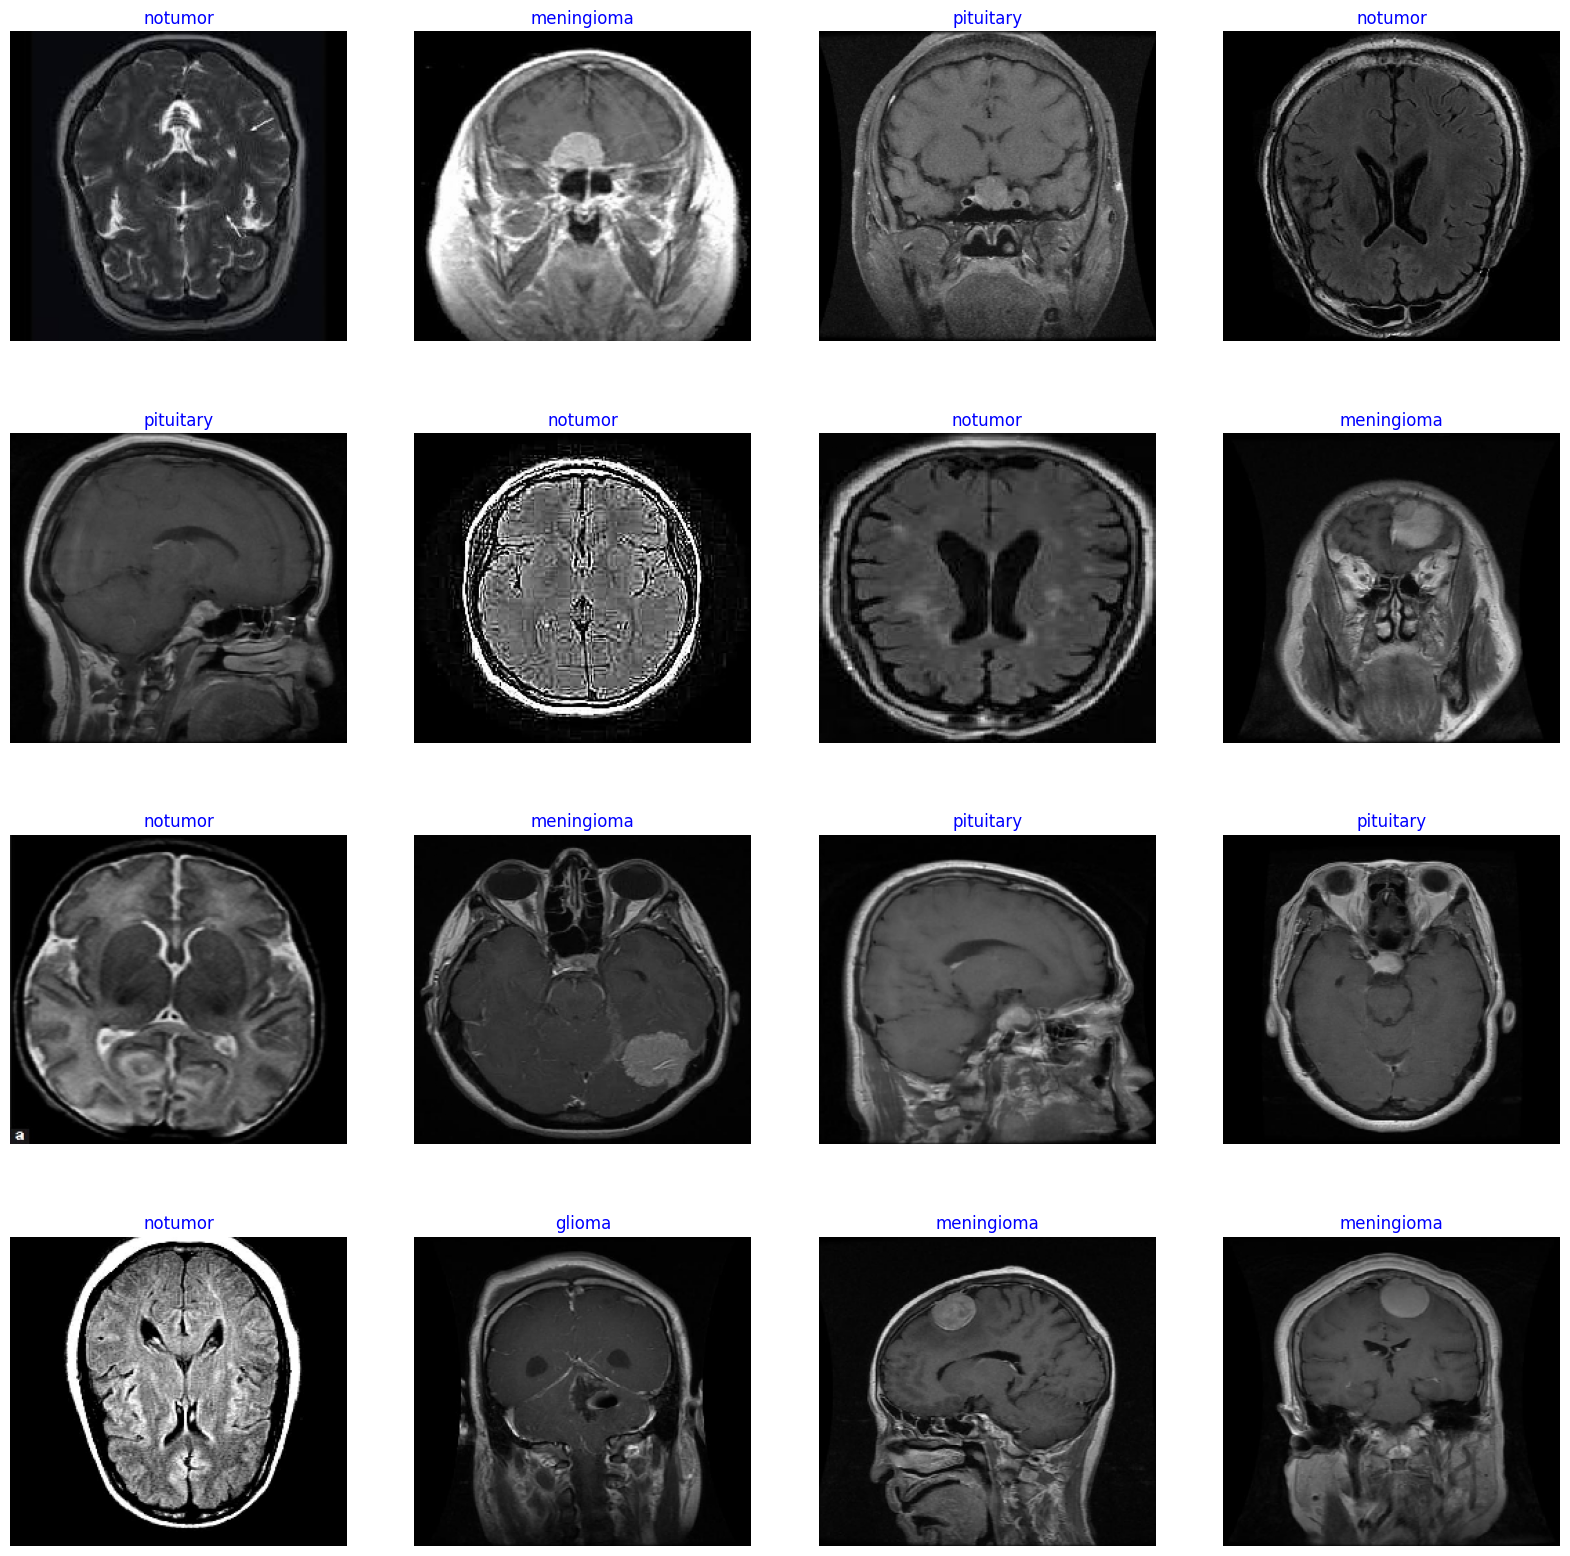

In [12]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images , labels = next(train_gen)

plt.figure(figsize= (20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'blue' , fontsize= 12)
    plt.axis('off')
plt.show();

In [13]:
## model structure

In [27]:
img_shape = (img_size[0] , img_size[1] , 3)
num_class = len(classes)

base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top = False , weights = 'imagenet' ,
                                                               input_shape = img_shape, pooling= 'max')
model = Sequential([
    base_model,
    BatchNormalization(axis= -1 , momentum= 0.99 , epsilon= 0.001),
    Dense(256, kernel_regularizer = regularizers.l2(l2= 0.016) , activity_regularizer = regularizers.l1(l1=0.006),
         bias_regularizer= regularizers.l1(l1=0.006) , activation = 'relu'),
    Dropout(rate= 0.4 , seed = 75),
    Dense(num_class , activation = 'softmax')
])

model.compile(Adamax(learning_rate = 0.001) , loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 1536)           │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,184,179 (42.66 MB)

 Trainable params: 11,093,804 (42.32 MB)

 Non-trainable params: 90,375 (353.03 KB)

In [15]:
## iterate

In [16]:
Epochs = 10

history = model.fit(x= train_gen , epochs = Epochs , verbose = 1 , validation_data = valid_gen ,
                   validation_steps = None , shuffle = False)

Epoch 1/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 3899s 11s/step - accuracy: 0.5548 - loss: 10.1725 - val_accuracy: 0.4427 - val_loss: 5.5423
Epoch 2/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 3677s 10s/step - accuracy: 0.5295 - loss: 5.0430 - val_accuracy: 0.5237 - val_loss: 3.6004
Epoch 3/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 3580s 10s/step - accuracy: 0.5353 - loss: 3.3112 - val_accuracy: 0.5313 - val_loss: 2.4753
Epoch 4/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 3552s 10s/step - accuracy: 0.5234 - loss: 2.3095 - val_accuracy: 0.5237 - val_loss: 1.8010
Epoch 5/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 3575s 10s/step - accuracy: 0.5194 - loss: 1.7619 - val_accuracy: 0.5267 - val_loss: 1.4565
Epoch 6/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 3582s 10s/step - accuracy: 0.5335 - loss: 1.4578 - val_accuracy: 0.5374 - val_loss: 1.2472
Epoch 7/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 3474s 10s/step - accuracy: 0.5584 - loss: 1.2852 - val_accuracy: 0.6748 - val_loss: 1.1174
Epoch 8/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 3497s 10s/step - accuracy: 0.6150 - loss: 

In [17]:
## model performance

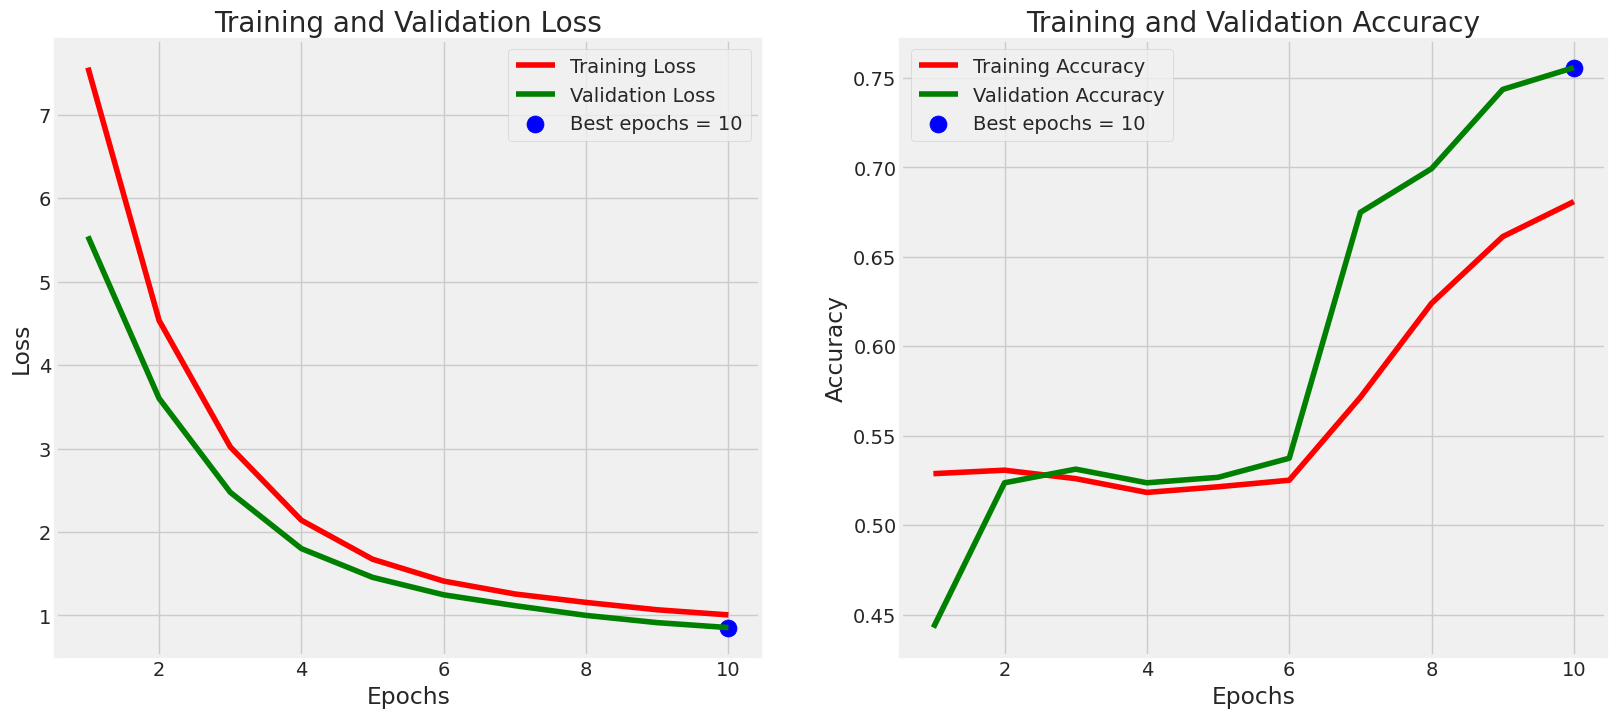

In [18]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

#Training history

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue',label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r' , label = 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'blue',label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show();

In [19]:
## Model Evaluation

In [20]:
train_score = model.evaluate(train_gen , steps =16 , verbose = 1)
valid_score = model.evaluate(valid_gen , steps = 16 , verbose = 1)
test_score = model.evaluate(test_gen , steps = 16 , verbose = 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.7430 - loss: 0.8464
16/16 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.6914 - loss: 0.8843
16/16 ━━━━━━━━━━━━━━━━━━━━ 78s 5s/step - accuracy: 0.7440 - loss: 0.8743
Train Loss:  0.8414000272750854
Train Accuracy:  0.75
--------------------
Validation Loss:  0.8694157004356384
Validation Accuracy:  0.734375
--------------------
Test Loss:  0.88038170337677
Test Accuracy:  0.73828125


In [25]:
## model prediction

In [26]:
## confucsion matrix and classification report

In [29]:
preds = model.predict(test_gen)

y_pred = np.argmax(preds , axis = 1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 162s 4s/step


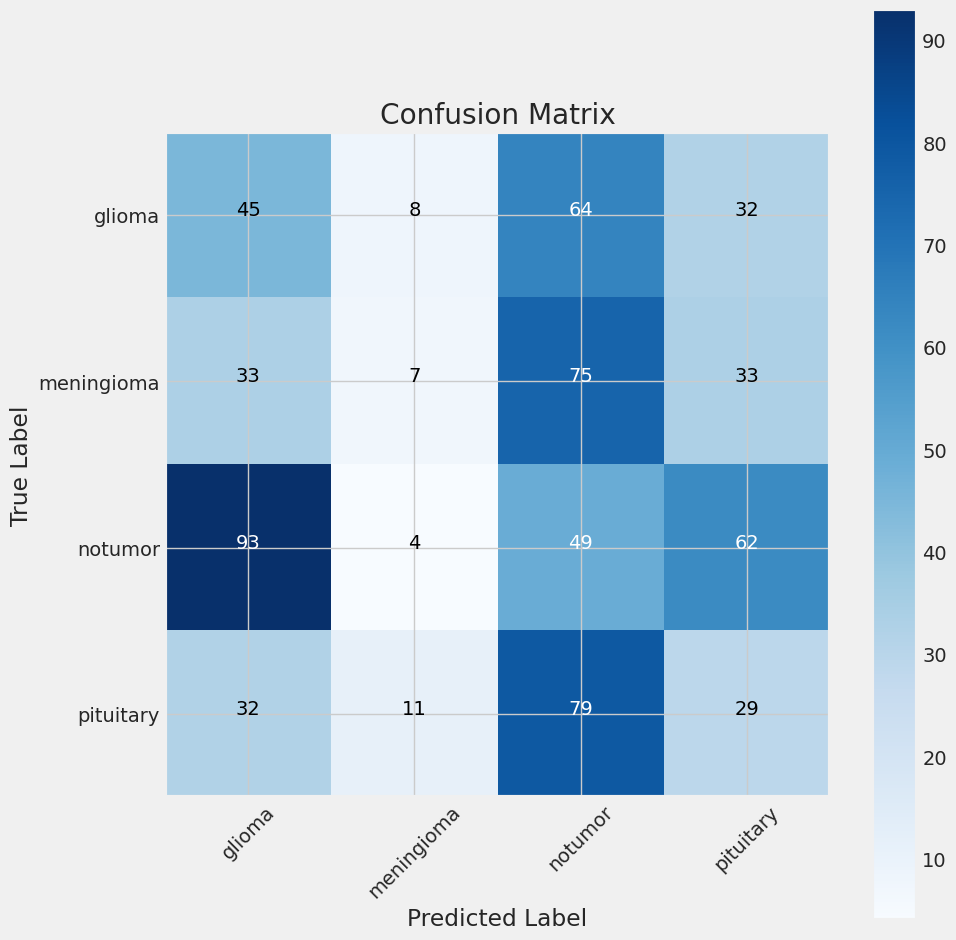

In [30]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [31]:
# Classification Report
print(classification_report(test_gen.classes, y_pred , target_names= classes ))

              precision    recall  f1-score   support

      glioma       0.22      0.30      0.26       149
  meningioma       0.23      0.05      0.08       148
     notumor       0.18      0.24      0.21       208
   pituitary       0.19      0.19      0.19       151

    accuracy                           0.20       656
   macro avg       0.21      0.19      0.18       656
weighted avg       0.20      0.20      0.18       656

